通过引入额外的Condition来控制生成的图片，即，在DCGAN或者WGAN的基础上加入Label属性条件。
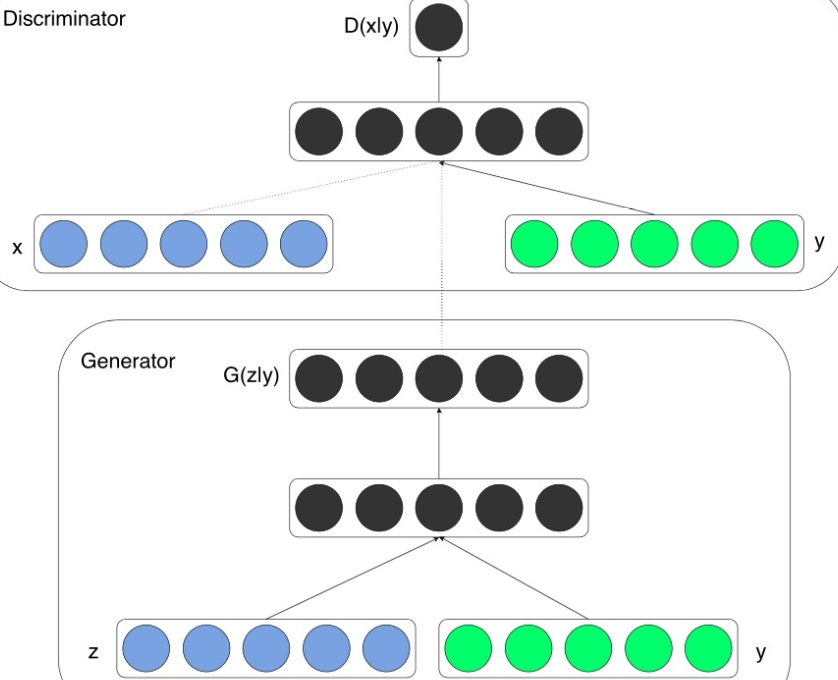

$$
\min _{G} \max _{D} V(D, G)=\mathbb{E}_{x \sim p_{\text {data }}}[\log D(x | y)]+\mathbb{E}_{z \sim p_{z}}[\log (1-D(G(z | y)))]
$$

### mnist实验

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, imageio
from tqdm import tqdm

In [11]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

OUTPUT_DIR = 'samples'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [4]:
batch_size = 100
z_dim = 100
WIDTH = 28
HEIGHT = 28
LABEL = 10  # 10类

#### input

In [5]:
X = tf.placeholder(dtype=tf.float32, shape=[None, HEIGHT, WIDTH, 1], name='X')
y_label = tf.placeholder(dtype=tf.float32, shape=[None, HEIGHT, WIDTH, LABEL], name='y_label')

noise = tf.placeholder(dtype=tf.float32, shape=[None, z_dim], name='noise')
y_noise = tf.placeholder(dtype=tf.float32, shape=[None, LABEL], name='y_noise')

is_training = tf.placeholder(dtype=tf.bool, name='is_training')

#### Layers

In [6]:
def lrelu(x, leak=0.2):
    return tf.maximum(x, leak * x)


def sigmoid_cross_entropy_with_logits(x, y):
    return tf.nn.sigmoid_cross_entropy_with_logits(logits=x, labels=y)


def discriminator(image, label, reuse=None, is_training=is_training, momentum=0.9):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # 将label作为输入，在最后一维加入label数据
        h0 = tf.concat([image, label], axis=3)
        h0 = lrelu(tf.layers.conv2d(h0, kernel_size=5, filters=64, strides=2, padding='same'))
        
        h1 = tf.layers.conv2d(h0, kernel_size=5, filters=128, strides=2, padding='same')
        h1 = lrelu(tf.contrib.layers.batch_norm(h1, is_training=is_training, decay=momentum))
        
        h2 = tf.layers.conv2d(h1, kernel_size=5, filters=256, strides=2, padding='same')
        h2 = lrelu(tf.contrib.layers.batch_norm(h2, is_training=is_training, decay=momentum))
        
        h3 = tf.layers.conv2d(h2, kernel_size=5, filters=512, strides=2, padding='same')
        h3 = lrelu(tf.contrib.layers.batch_norm(h3, is_training=is_training, decay=momentum))
        
        h4 = tf.contrib.layers.flatten(h3)
        h4 = tf.layers.dense(h4, units=1)
        
        return tf.nn.sigmoid(h4), h4
    
    
def generator(z, label, is_training=is_training, momentum=0.9):
    """z, label：noise输入"""
    with tf.variable_scope('generator', reuse=None):
        d = 3
        z = tf.concat([z, label], axis=1)
        h0 = tf.layers.dense(z, units=d * d * 512)
        h0 = tf.reshape(h0, shape=[-1, d, d, 512])
        h0 = tf.nn.relu(tf.contrib.layers.batch_norm(h0, is_training=is_training, decay=momentum))
        
        h1 = tf.layers.conv2d_transpose(h0, kernel_size=5, filters=256, strides=2, padding='same')
        h1 = tf.nn.relu(tf.contrib.layers.batch_norm(h1, is_training=is_training, decay=momentum))
        
        h2 = tf.layers.conv2d_transpose(h1, kernel_size=5, filters=128, strides=2, padding='same')
        h2 = tf.nn.relu(tf.contrib.layers.batch_norm(h2, is_training=is_training, decay=momentum))
        
        h3 = tf.layers.conv2d_transpose(h2, kernel_size=5, filters=64, strides=2, padding='same')
        h3 = tf.nn.relu(tf.contrib.layers.batch_norm(h3, is_training=is_training, decay=momentum))
        
        h4 = tf.layers.conv2d_transpose(h3, kernel_size=5, filters=1, strides=1, padding='valid', activation=tf.nn.tanh, name='g')
        return h4

#### Graph

In [7]:
g = generator(noise, y_noise)
d_real, d_real_logits = discriminator(X, y_label)
d_fake, d_fake_logits = discriminator(g, y_label, reuse=True)

vars_g = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]

loss_d_real = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_real_logits, tf.ones_like(d_real)))
loss_d_fake = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_fake_logits, tf.zeros_like(d_fake)))
loss_g = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_fake_logits, tf.ones_like(d_fake)))
loss_d = loss_d_real + loss_d_fake

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(loss_d, var_list=vars_d)
    optimizer_g = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(loss_g, var_list=vars_g)

#### train and display

In [8]:
def montage(images):
    if isinstance(images, list):
        images = np.array(images)
    
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    m = np.ones((images.shape[1] * n_plots + n_plots + 1, images.shape[2] * n_plots + n_plots + 1)) * 0.5
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    return m

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 随机输入
z_samples = np.random.uniform(-1.0, 1.0, [batch_size, z_dim]).astype(np.float32)
y_samples = np.zeros([batch_size, LABEL])

# 生成10行0label，10行1label，。。。，10行9label
for i in range(LABEL):
    for j in range(LABEL):
        y_samples[i * LABEL + j, i] = 1

samples = []
loss = {'d': [], 'g': []}


for i in tqdm(range(60000)):
    # 图像生成noise
    n = np.random.uniform(-1.0, 1.0, [batch_size, z_dim]).astype(np.float32)
    # 真实图像
    batch, label = mnist.train.next_batch(batch_size=batch_size)
    batch = np.reshape(batch, [batch_size, HEIGHT, WIDTH, 1])
    batch = (batch - 0.5) * 2
    
    # 生成器label
    yn = np.copy(label)
    # 判别器label
    yl = np.reshape(label, [batch_size, 1, 1, LABEL])
    yl = yl * np.ones([batch_size, HEIGHT, WIDTH, LABEL])
    
    # 计算loss
    d_ls, g_ls = sess.run([loss_d, loss_g], feed_dict={X: batch, noise: n, y_label: yl, y_noise: yn, is_training: True})
    loss['d'].append(d_ls)
    loss['g'].append(g_ls)
    
    # dcgan的一般训练策略
    sess.run(optimizer_d, feed_dict={X: batch, noise: n, y_label: yl, y_noise: yn, is_training: True})
    sess.run(optimizer_g, feed_dict={X: batch, noise: n, y_label: yl, y_noise: yn, is_training: True})
    sess.run(optimizer_g, feed_dict={X: batch, noise: n, y_label: yl, y_noise: yn, is_training: True})
    
    # 显示结果
    if i % 1000 == 0:
        print(i, d_ls, g_ls)
        gen_imgs = sess.run(g, feed_dict={noise: z_samples, y_noise: y_samples, is_training: False})
        gen_imgs = (gen_imgs + 1) / 2
        imgs = [img[:, :, 0] for img in gen_imgs]
        gen_imgs = montage(imgs)
        plt.axis('off')
        plt.imshow(gen_imgs, cmap='gray')
        imageio.imsave(os.path.join(OUTPUT_DIR, 'sample_%d.jpg' % i), gen_imgs)
        plt.show()
        samples.append(gen_imgs)

saver = tf.train.Saver()
saver.save(sess, './mnist_cgan', global_step=60000)
        
plt.plot(loss['d'], label='Discriminator')
plt.plot(loss['g'], label='Generator')
plt.legend(loc='upper right')
plt.savefig('Loss.png')
plt.show()
imageio.mimsave(os.path.join(OUTPUT_DIR, 'samples.gif'), samples, fps=5)